In [3]:
from __future__ import print_function

import os
import time

import numpy as np
import tensorflow as tf
import scipy.io
from six.moves import urllib
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import vgg_model #to use the pretrained vgg_model
import utils #some utility functions, like resizing the image, saving the image etc to

In [4]:
#name of the style image
STYLE = 'starry_night'
#name of the content image
CONTENT = 'tubingen'
STYLE_IMAGE = 'styles/' + STYLE + '.jpg'
CONTENT_IMAGE = 'content/' + CONTENT + '.jpg'
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 333
NOISE_RATIO = 0.6 # percentage of weight of the noise for intermixing with the content image

# Layers used for style features. You can change this.
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
W = [0.5, 1.0, 1.5, 3.0, 4.0] # give more weights to deeper layers.

# Layer used for content features. You can change this.
CONTENT_LAYER = 'conv4_2'

ITERS = 300
#learning rate
LR = 2.0

#mean of the pixels of the images that were used to train VGG net 
MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

VGG_DOWNLOAD_LINK = 'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
EXPECTED_BYTES = 534904783

In [5]:
#Defining the content loss function
def _create_content_loss(p, f):
    #inputs 
        #p: feature map of the content image
        #f: feature map of the input_image
    #outputs the content loss which is defined as: summation((f-p)^2)/(4*size_of_feature_map)
    content_loss = tf.reduce_sum(tf.square(f-p))/(4*p.size)
    return content_loss

In [7]:
#Defining the gram matrix function
def _gram_matrix(F, N, M):
    #inputs
        #F: feature maps 
        #M: width*height of a feature map
        #N: depth of the feature map
    #outputs the gram matrix which gives the correlation between the pair of activations and is defined as F'*F
    F = tf.reshape(F,(M,N))
    G = tf.matmul(tf.transpose(F),F)
    return G

In [8]:
#Defining the style loss function for a particular layer
def _single_style_loss(a, g):
    #inputs
        #a: feature map of the style image
        #g: feature map of the input_image
    #outputs the style loss for a particular activation layer,
    #defined as sum of squares of the differences between the gram matrices of both a and g
    M = a.shape[1]*a.shape[2]
    N = a.shape[3]
    #getting the gram matrices
    G_a = _gram_matrix(a,N,M)
    G_g = _gram_matrix(g,N,M)
    style_loss = (0.5/(M*N)**2)*tf.reduce_sum(tf.square(G_a-G_g))
    return style_loss

In [9]:
#Defining the function which calculates the total style loss
def _create_style_loss(A, model):
    #inputs
        #A: A is a list containing the feature maps for different conv layers
        #model: Our computaional graph containing activation of the input image in different layers, along with other
                #parameters required for optimization
    n_layers = len(STYLE_LAYERS)
    style_losses = []
    for i in range(n_layers):
        style_losses.append(_single_style_loss(A[i],model[STYLE_LAYERS[i]]))
    loss = 0
    for i in range(n_layers):
        loss += W[i]*style_losses[i] #remember W is a list of weights of contribution of different layers to the style loss
    return loss

In [10]:
#Defining the function create_losses which finds the net loss, content loss + style loss
def _create_losses(model, input_image, content_image, style_image):
    #inputs
        #model: Our computaional graph containing activation of the input image in different layers, along with other
                #parameters required for optimization
        #input_image:
        #content_image:
        #styel_image
    with tf.variable_scope('loss') as scope:
        
        #finding content loss
        with tf.Session() as sess:
            sess.run(input_image.assign(content_image)) # assign content image to the input variable
            p = sess.run(model[CONTENT_LAYER])
        content_loss = _create_content_loss(p, model[CONTENT_LAYER])
        
        #finding style loss
        with tf.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = sess.run([model[layer_name] for layer_name in STYLE_LAYERS])
        style_loss = _create_style_loss(A, model)

        total_loss = 0.001*content_loss + 1*style_loss #total loss as the weigthed sum of content and style loss
                                                      #feel free to tweak the weights, 1/50 and 1/20 are also quite common  

    return content_loss, style_loss, total_loss

In [11]:
#training our model
def train(model, generated_image, initial_image):
    #inputs
        #model: Our computaional graph containing activation of the input image in different layers, along with other
                #parameters required for optimization
        #generated_image: imput image
        #initial_image: the initial image, which is just the content image with some noise
    skip_step = 1
    with tf.Session() as sess:
        saver = tf.train.Saver()
        #initializing the variables
        sess.run(tf.global_variables_initializer())
        #here we are assigning the initial_image to the variable generated_image which is nothing but our input image
        sess.run(generated_image.assign(initial_image))
        #checking whether a checkpoint exists. A checkpoint is basically used to save our model while training, 
        #so that we dont need to start the training from scratch every time.
        #in our case since we are running this for the first time there wont be any checkpoint initially
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        #global_step basically contains the number of training steps which have happened till now i.e number of
        #optimization steps
        initial_step = model['global_step'].eval()

        start_time = time.time()
        
        #Training start
        for index in range(initial_step, ITERS):
            if index >= 5 and index < 20:
                skip_step = 10
            elif index >= 20:
                skip_step = 20
            #skip_step is used to print the losses, save the checkpoint and generated images at specific steps of iteration
            #and not at all the iterations. you can choose it as whatever you like.
            #running the optimizer
            sess.run(model['optimizer'])
            if (index + 1) % skip_step == 0:
                #getting the generated image and total loss at the skip_step
                gen_image = sess.run(generated_image)
                total_loss = sess.run(model['total_loss'])
                gen_image = gen_image + MEAN_PIXELS
                #printing the total loss
                print('Step {}\n   Sum: {:5.1f}'.format(index + 1, np.sum(gen_image)))
                print('   Loss: {:5.1f}'.format(total_loss))
                print('   Time: {}'.format(time.time() - start_time))
                
                plt.imshow(gen_image[0])
                plt.show()
                start_time = time.time()
                #saving the image
                filename = 'outputs/%d.png' % (index)
                utils.save_image(filename, gen_image)
                #saving the checkpoint
                if (index + 1) % 20 == 0:
                    saver.save(sess, 'checkpoints/style_transfer', index)


Dataset ready
Step 1
   Sum: 28487995.3
   Loss: 3797335552.0
   Time: 19.27033519744873


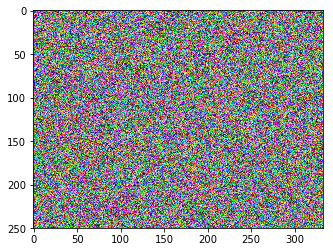

Step 2
   Sum: 28486614.1
   Loss: 3131104512.0
   Time: 17.82795763015747


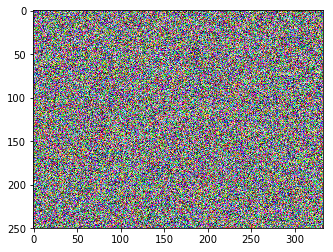

Step 3
   Sum: 28486145.9
   Loss: 2570863616.0
   Time: 8.798370122909546


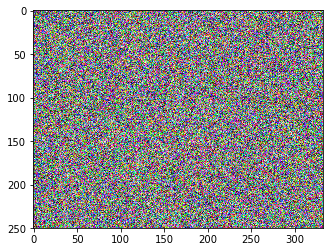

Step 4
   Sum: 28486881.9
   Loss: 2128191488.0
   Time: 10.283119201660156


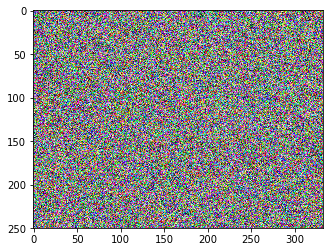

In [ ]:
with tf.variable_scope('input') as scope:
    # use variable instead of placeholder because we're training the intial image to make it
    # look like both the content image and the style image
    input_image = tf.Variable(np.zeros([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]), dtype=tf.float32)

#Downloading the pre trained VGG_MODEL weights    
utils.download(VGG_DOWNLOAD_LINK, VGG_MODEL, EXPECTED_BYTES)
#model is our computational graph, conataing activations of the input image in different layers and other things
#like optimizer,loss essential for training
model = vgg_model.load_vgg(VGG_MODEL, input_image)
model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

#resizing and normalizing the content image
content_image = utils.get_resized_image(CONTENT_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
content_image = content_image - MEAN_PIXELS
style_image = utils.get_resized_image(STYLE_IMAGE, IMAGE_HEIGHT, IMAGE_WIDTH)
style_image = style_image - MEAN_PIXELS

#getting the content_loss, style_loss and total_loss
model['content_loss'], model['style_loss'], model['total_loss'] = _create_losses(model,
                                                    input_image, content_image, style_image)

#creating an optimizer, I am using Adam Optimizer, you can also use RMS Prop or Adagrad
model['optimizer'] = tf.train.AdamOptimizer(LR).minimize(model['total_loss'],model['global_step'])

#initializing the initial image as the content_image with some noise generated over it
initial_image = utils.generate_noise_image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
#Let the training begin
train(model, input_image, initial_image)